# 5. 폐렴아 기다려라!(실습)

## 1. Set-up

In [55]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [56]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [224, 224]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 15
EPOCHS = 20

print(ROOT_PATH)

/aiffel/aiffel


## 2. 데이터 가져오기

:  val 개수가 너무 없기 때문에 train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할

In [32]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [33]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [34]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [35]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많음<br>
CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 함<br>
데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정<br>
test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제없습니다.

* tf.data 인스턴스: tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해줌

In [36]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [37]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


* 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들기

In [38]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

* 이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄이기<br>
: process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경<br>
: get_label을 이용해서 라벨 값을 가져오기

In [39]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

* train 데이터 셋과 validation 데이터 셋을 만들기<br>
: num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리

In [40]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [41]:
for image, label in train_ds.take(1):  # train_ds.take(1) 하나의 데이터만 가져온다는 의미
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


* test 데이터셋 만들기

In [43]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


> tf.data 파이프라인 :  학습 데이터를 효율적으로 사용<br>
> tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환

* shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
* repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줌
* batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어짐
* prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있음

In [44]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 3. 데이터 시각화
* 데이터를 보기 위해 train에 있는 batch 중 첫 번째 배치를 추출
* 추출된 배치를 image와 label 데이터 셋으로 나눠서 확인

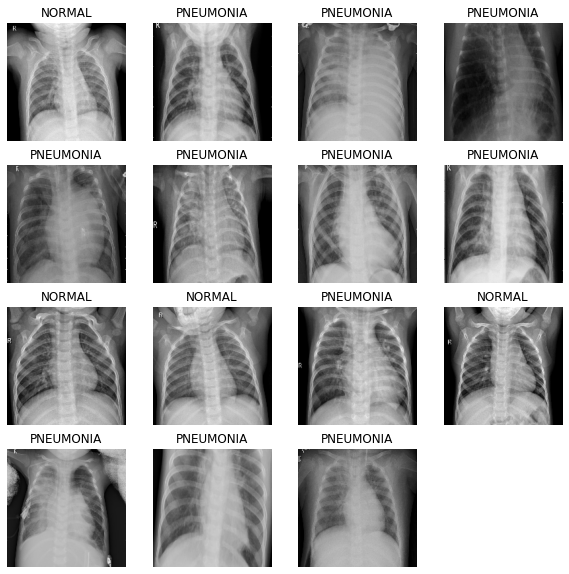

In [45]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 4. CNN 모델링
* conv_block()의 구성: 
* Convolution을 두 번 진행 
* Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결
* Max Pooling을 합니다.

In [46]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [47]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

* 위의 모델은 Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용되고 있습니다.
* 일반적으로 이런 방법은 잘 사용되지 않거나, 금기시되기도 합니다

In [48]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5. 데이터 imbalance 처리
: 한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있습니다.
<br>`해결방법` : Weight balancing이라는 테크닉이 사용

```note
Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다. Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원함
```

* weight_for_0은 'Normal' 이미지에 사용할 weight
* weight_for_1은 'Pneumonia' 이미지에 사용할 weight
<br> 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정

In [49]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## 6. 모델 훈련
: 이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택합니다. 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언
    
* loss: 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy"
* optimizer: 'adam'
* metrics으로 'accuracy', 'precision', 'recall'을 사용

In [50]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss', patience=5)

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    

In [51]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[early_stopping]
    )

Epoch 1/20
279/279 [==============================] - 67s 193ms/step - loss: 0.4160 - accuracy: 0.8045 - precision: 0.9481 - recall: 0.7801 - val_loss: 0.6491 - val_accuracy: 0.7333 - val_precision: 0.7333 - val_recall: 1.0000
Epoch 2/20
279/279 [==============================] - 54s 195ms/step - loss: 0.2272 - accuracy: 0.9116 - precision: 0.9744 - recall: 0.9050 - val_loss: 1.3722 - val_accuracy: 0.7362 - val_precision: 0.7362 - val_recall: 1.0000
Epoch 3/20
279/279 [==============================] - 54s 193ms/step - loss: 0.1875 - accuracy: 0.9276 - precision: 0.9802 - recall: 0.9213 - val_loss: 0.2499 - val_accuracy: 0.8879 - val_precision: 0.8676 - val_recall: 1.0000
Epoch 4/20
279/279 [==============================] - 54s 195ms/step - loss: 0.1984 - accuracy: 0.9278 - precision: 0.9766 - recall: 0.9252 - val_loss: 0.3801 - val_accuracy: 0.8744 - val_precision: 1.0000 - val_recall: 0.8285
Epoch 5/20
279/279 [==============================] - 55s 199ms/step - loss: 0.1682 - accura

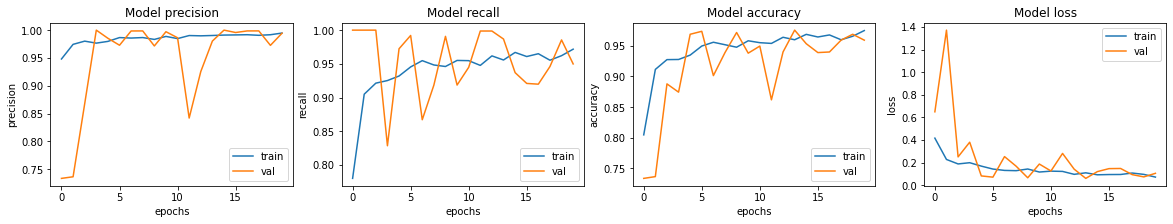

In [52]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [53]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

42/42 [==============================] - 7s 158ms/step - loss: 0.7504 - accuracy: 0.8301 - precision: 0.7996 - recall: 0.9718
Loss: 0.7503821849822998,
Accuracy: 0.8301281929016113,
Precision: 0.799578070640564,
Recall: 0.971794843673706


---
**회고**

<br>GPU환경에서 학습을 진행하니 시간은 좀 걸리긴 하지만 커널이 끊기지는 않아서 좋았다. 
<br>다만, LMS 상에서 주어진 기본 파라미터 설정만 진행했을때는 80% 도 아닌 60%대의 정확도를 보여 Epoch 수행후 acc가 95%라서 Epoch 수를 20으로 학습을 추가 진행해보았다.
<br>다음 퀘스트에서 파라미터 변경으로 모델 개선을 하는 step이 있어 나머지는 이후 변경해보면서 진행하고자 한다. 


___

# 6-1. 프로젝트 : 폐렴 진단기 성능개선

In [32]:
import tensorflow

print(tensorflow.__version__)

2.6.0


### Step 1. 실험환경 Set-up
: Batch size, Epoch 등을 변경

In [57]:
BATCH_SIZE = 30
EPOCHS = 20

### Step 2. 데이터 준비하기
:원본 데이터를 가져와서 전처리 및 배치 구성을 진행
* 좌우 반전 정도의 augmentation만 도입

In [58]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [59]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [60]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [61]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [62]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [63]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [64]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [65]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [66]:
for image, label in train_ds.take(1):  # train_ds.take(1) 하나의 데이터만 가져온다는 의미
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  False


In [67]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [68]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

In [69]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### Step 3. 데이터 시각화
: augmentation을 시도했다면 이후 실습 코드에 있는 show_batch() 함수를 통해 실제로 좌우 반전 등이 제대로 처리되었는지 확인

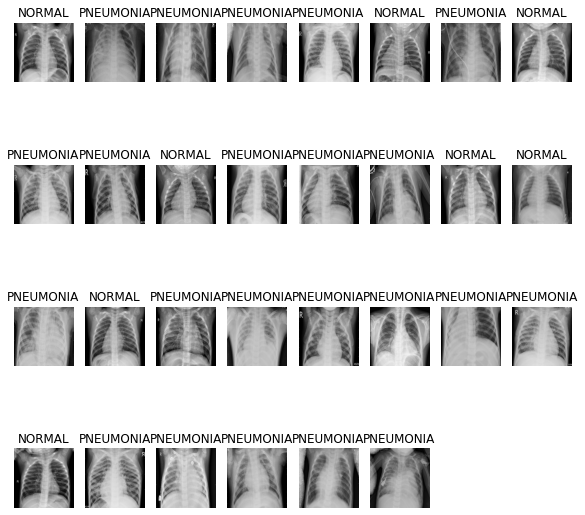

In [70]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### Step 4. ResNet-18 구현 : ResNet의 가장 작은 버전 ResNet-18
: 의료 영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험
<br>Convolution filter, 채널 개수, activation, 모델 구조 등을 다양하게 바꿔보기

> **ResNet의 특징**<br>
: Residual Connection으로 학습된 정보가 데이터 처리과정에서 손실되는 것을 방지<br>
: ResNet의 Residual Connection은 이후에 나오는 Transformer와 같은 모델에도 사용됨

#### 1. Residual block 구성

* weight layer
<br>3x3 CNN
<br>BatchNormalization

![Residula Connection](https://d3s0tskafalll9.cloudfront.net/media/images/residual_connection.max-800x600.png)
<br>
<br>
![ResNet18](https://d3s0tskafalll9.cloudfront.net/media/images/resnet-18.max-800x600.png)
*해당 table은 ImageNet Challenge를 가정했기 때문에 filter개수는 튜닝하면서 바꿔주세요

In [71]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,GlobalAveragePooling2D, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, AveragePooling2D, Flatten, Dense, ZeroPadding2D


In [76]:
def resnet_block(inputs,kernel,filters,strides=1,activation='relu'):
    
    x=Conv2D(filters,kernel_size=(kernel,kernel),strides=strides, padding='same')(inputs)
    
    x=BatchNormalization()(x)
    
    x=Activation(activation)(x)
    
    x=Conv2D(filters,kernel_size=(kernel,kernel),padding='same')(x)
    
    x=BatchNormalization()(x)
    
    if strides != 1 or inputs.shape[3] != filters:    
       inputs = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(inputs)
       inputs = BatchNormalization()(inputs)
    
    x=Add()([inputs,x])
    
    x=Activation(activation)(x)
    
    return x
        

* Convolution -> BatchNormalization-> Activation -> Convolution -> BatchNormalization -> Add -> Activation
* CNN에서 입력 데이터는 일반적으로 (batch_size, height, width, channels) 형태의 4차원텐서로 표현
* 프로젝트 숏컷: if strides != 1 or inputs.shape[3] != filters: 
<br>: inputs 텐서의 스트라이드가 1이 아니거나 채널 수가 filters와 다를 경우, 1x1 컨볼루션으로 차원을 조정하고 배치 정규화를 적용
<br> "resnet_block"을 사용할 때, ResNet의 핵심 아이디어 중 하나인 "skip connection" 또는 "shortcut connection"을 구현하기 위해 입력과 출력을 합치는 과정이 있습니다. 
<br>입력과 출력이 같은 차원을 가져야 하기 때문에, 차원이 다른 경우에는 일반적으로 1x1 컨볼루션 레이어를 사용하여 입력 텐서의 차원을 조정


In [77]:
def resnet_18(input_shape,num_classes):
    
    inputs=Input(shape=input_shape)
    
    x=Conv2D(64,kernel_size=(7,7),strides=(2,2),padding='same')(inputs)
    x=BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x=MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
    
    x=resnet_block(x,3,64)
    x=resnet_block(x,3,64)
    x=resnet_block(x,3,64)
    x=resnet_block(x,3,64)
    x=resnet_block(x,3,128)
    x=resnet_block(x,3,128)
    x=resnet_block(x,3,128)
    x=resnet_block(x,3,128)
    x=resnet_block(x,3,256)
    x=resnet_block(x,3,256)
    x=resnet_block(x,3,256)
    x=resnet_block(x,3,256)
    x=resnet_block(x,3,512)
    x=resnet_block(x,3,512)
    x=resnet_block(x,3,512)    
    x=resnet_block(x,3,512) 
    
    x=AveragePooling2D(pool_size=(7, 7), strides=(1, 1))(x)
    
    x=Flatten()(x)
    
    x=Dense(1,activation='sigmoid')(x)
    
    model=Model(inputs=inputs, outputs=x)
    
    return model
    

In [78]:
image.numpy().shape

(224, 224, 3)

In [79]:
input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3) #이미지의 크기
num_classes=2 #클래스의 숫자
model = resnet_18(input_shape, num_classes)

model.summary()


Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_303 (Conv2D)             (None, 112, 112, 64) 9472        input_15[0][0]                   
__________________________________________________________________________________________________
batch_normalization_303 (BatchN (None, 112, 112, 64) 256         conv2d_303[0][0]                 
__________________________________________________________________________________________________
activation_263 (Activation)     (None, 112, 112, 64) 0           batch_normalization_303[0][0]    
___________________________________________________________________________________________

### Step 5. 데이터 imbalance 처리
:데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정

In [80]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


### Step 6. 모델 훈련
:loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려

In [81]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss', patience=5)

with tf.device('/GPU:0'):
    model = resnet_18(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), num_classes = 2)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )


In [82]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[early_stopping]
    )

Epoch 1/20
139/139 [==============================] - 259s 2s/step - loss: 10.1742 - accuracy: 0.8000 - precision: 0.9204 - recall: 0.8007 - val_loss: 4.0704 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 2/20
139/139 [==============================] - 238s 2s/step - loss: 0.2862 - accuracy: 0.9211 - precision: 0.9730 - recall: 0.9193 - val_loss: 3.3151 - val_accuracy: 0.7353 - val_precision: 0.7353 - val_recall: 1.0000
Epoch 3/20
139/139 [==============================] - 238s 2s/step - loss: 0.1782 - accuracy: 0.9496 - precision: 0.9843 - recall: 0.9475 - val_loss: 0.6695 - val_accuracy: 0.7902 - val_precision: 0.7779 - val_recall: 0.9987
Epoch 4/20
139/139 [==============================] - 239s 2s/step - loss: 0.1308 - accuracy: 0.9535 - precision: 0.9847 - recall: 0.9524 - val_loss: 0.2290 - val_accuracy: 0.9088 - val_precision: 0.8983 - val_recall: 0.9880
Epoch 5/20
139/139 [==============================] - 238s 2s/step - loss: 0.0986 - accuracy: 0.963

### Step 7. 결과 확인과 시각화
: 우선은 accuracy를 고려해야겠지만 의료 영상 모델의 특성상 recall도 중요. 훈련과정의 history 그래프를 시각화

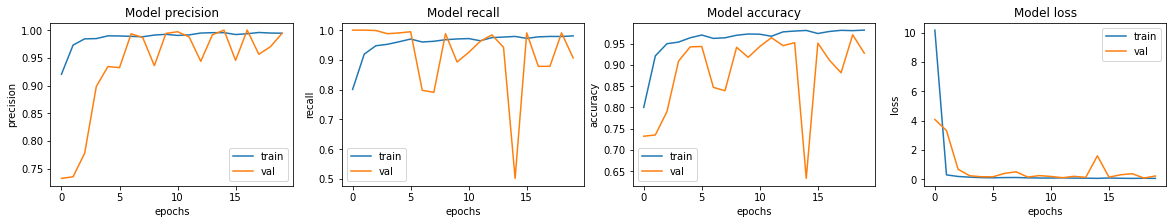

In [83]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [84]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

21/21 [==============================] - 14s 633ms/step - loss: 0.7146 - accuracy: 0.8333 - precision: 0.8095 - recall: 0.9590
Loss: 0.7146484851837158,
Accuracy: 0.8333333134651184,
Precision: 0.8095238208770752,
Recall: 0.9589743614196777


---
**회고**

주어진 Resnet-18을 구현해야하는 이미지 상에서 출력레이어의 활성화함수가 Softmax 함수로 되어있어 모델의 출력(logits)과 실제 레이블(labels)의 형태가 일치 하지 않는 오류가 발생하였다. 해결방법으로는 
1. 이진분류에 적합한 활성화 함수인 sigmoid 함수로 변경
2. 레이블을 원핫인코딩을 하여 형태를 맞추는 방법
이 있는데 1번을 택해서 수행하였다.

실습노드에서 진행했던 CNN 모델보다 성능이 좋지 않아 원인 분석을 좀 더 해봐야 할 것 같다. 

**참고사이트**
[ResNet-18 코드](https://velog.io/@stilltravel/AI-ResNet-18-Layer)